In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import shapiro
import scipy.stats as stats
import warnings

In [49]:
from scipy.stats import shapiro
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

In [50]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.style.use('ggplot')
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

 

from tqdm.auto import tqdm

In [51]:
ab = pd.read_csv('ab_data.csv.zip')

In [52]:
ab

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1
...,...,...,...,...,...
294475,734608,45:03.4,control,old_page,0
294476,697314,20:29.0,control,old_page,0
294477,715931,40:24.5,treatment,new_page,0
294478,759899,20:29.0,treatment,new_page,0


In [53]:
#проверяем на наличие повторяющихся ID
print(ab.user_id.nunique()==ab.shape[0])

False


In [54]:
#удалим 
ab.user_id.nunique()

290585

In [55]:
ab.shape

(294480, 5)

In [56]:
double_variant_count =ab.groupby('user_id')['group'].nunique().value_counts()
double_variant_count

1    288690
2      1895
Name: group, dtype: int64

In [57]:
double_variant_count / double_variant_count.sum()

1   0.9935
2   0.0065
Name: group, dtype: float64

In [58]:
#процент дублированных пользователей небольшой, но мы все-таки их удалим
single_variant_users = (ab.groupby('user_id')['group'].nunique() == 1)
single_variant_users = single_variant_users[single_variant_users]

In [59]:
3790/2/294480*100

0.643507199130671

In [60]:
ab = ab[ab['user_id'].isin(single_variant_users.index)]
ab.group.value_counts()

treatment    145383
control      145307
Name: group, dtype: int64

In [61]:
ab.landing_page.value_counts()

new_page    145399
old_page    145291
Name: landing_page, dtype: int64

In [62]:
ab['new']=ab.landing_page+ab.group

In [63]:
ab.new.value_counts()

new_pagetreatment    144392
old_pagecontrol      144300
new_pagecontrol        1007
old_pagetreatment       991
Name: new, dtype: int64

294480 - изначальный размер датасета и итоговый без дублирующих значений - 290690, по 1895 значений удалили из каждой группы

In [64]:
ab.groupby(by=['landing_page', 'group']).count()

user_id  timestamp  converted     new
landing_page group                                           
new_page     control       1007       1007       1007    1007
             treatment   144392     144392     144392  144392
old_page     control     144300     144300     144300  144300
             treatment      991        991        991     991

In [65]:
#посчитаем количество конвертированных и неконвертированных пользователей в тестовой и контрольной группах
ab.groupby(['group', 'converted']).agg({'converted': 'count'})

converted
group     converted           
control   0             127820
          1              17487
treatment 0             128093
          1              17290

In [66]:
#посчитаем количество конвертированных и неконвертированных пользователей в тестовой и контрольной группах
ab.groupby(['landing_page', 'converted']).agg({'converted': 'count'})

converted
landing_page converted           
new_page     0             128114
             1              17285
old_page     0             127799
             1              17492

In [67]:
# get metrics by groups
all_stat = ab.groupby(by='group').agg({'group': 'nunique',
                                               'converted': ['sum', 'mean', 'median', 'count']})

In [68]:
all_stat

group converted                      
          nunique       sum   mean median   count
group                                            
control         1     17487 0.1203 0.0000  145307
treatment       1     17290 0.1189 0.0000  145383

In [69]:
# get metrics by groups
all_stat_2 = ab.groupby(by='landing_page').agg({'landing_page': 'nunique',
                                               'converted': ['sum', 'mean', 'median', 'count']})

In [70]:
all_stat_2

landing_page converted                      
                  nunique       sum   mean median   count
landing_page                                             
new_page                1     17285 0.1189 0.0000  145399
old_page                1     17492 0.1204 0.0000  145291

In [71]:
#проводим непараметрический тест для анализа статистической разницы на контрольной и тестовой группах
mannwhitneyu(ab.loc[ab.group == 'treatment', 'converted'], ab.loc[ab.group == 'control', 'converted'])

MannwhitneyuResult(statistic=10547606545.0, pvalue=0.23886297613408058)

In [72]:
#проводим непараметрический тест для анализа статистической разницы на группе old_page и new_page
mannwhitneyu(ab.loc[ab.landing_page == 'old_page', 'converted'], ab.loc[ab.landing_page == 'new_page', 'converted'])

MannwhitneyuResult(statistic=10578565241.0, pvalue=0.2088030012936527)

p-value больше 0.05 - принимаем нулевую гипотезу - разница статистически не значима.

Попробуем провести анализ bootstrap

In [73]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    column_1, # числовые значения первой выборки
    column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(column_1), len(column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = column_1.sample(
            boot_len,
            replace = True # параметр возвращения
        ).values
        
        samples_2 = column_2.sample(
            boot_len,
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data,
            "ci": ci,
            "p_value": p_value}

In [91]:
#создаем 2 дата-сета, первый по тестовой, во второй- по контрольой группе (x,y колонки соответственно)
ab1 = pd.DataFrame()
ab2 = pd.DataFrame()
ab1['x']=ab.converted[ab['group']=='control']
ab2['y']=ab.converted[ab['group']=='treatment']

In [92]:
booted_data = get_bootstrap(ab_1.x, ab_2.y, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

AttributeError: 'DataFrame' object has no attribute 'y'

In [ ]:
booted_data["p_value"] #значение p-value > 0.05

In [ ]:
booted_data["ci"] #в границы доверительного интервала попадает 0

#Ноль попадает в доверительный интервал - это видно по графику и по выведенным значениям доверительного интервала.

А также значение p-value > 0.05. Это означает, что мы принимаем нулевую гипотезу, и говорим о том, что разницы между тестируемыми группами нет, что было также подтверждено проведенным ранее непараметрическим тестом Манна-Уитни

In [ ]:
#Попробуем провести анализ bootstrap на группах old_page и new_page
ab_3 = pd.DataFrame()
ab_4 = pd.DataFrame()
ab_3['x']=ab.converted[ab['landing_page']=='new_page']
ab_4['y']=ab.converted[ab['landing_page']=='old_page']

In [ ]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа (статистика - медиана)
def get_bootstrap_1(
    column_1, # числовые значения первой выборки
    column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(column_1), len(column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = column_1.sample(
            boot_len,
            replace = True # параметр возвращения
        ).values
        
        samples_2 = column_2.sample(
            boot_len,
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data,
            "ci": ci,
            "p_value": p_value}

In [ ]:
booted_data_1 = get_bootstrap(ab_3.x, ab_4.y, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [93]:
booted_data_1["p_value"]

0.2191283316863294

In [94]:
booted_data_1["ci"]

,0
0.0250,-0.0040
0.9750,0.0008


Результаты идентчные предыдущим

In [95]:
#Теперь попробуем удалить группы пользователей, где не совпадает условие control=old_page и treatment=new_page
ab.new.value_counts()

new_pagetreatment    144392
old_pagecontrol      144300
new_pagecontrol        1007
old_pagetreatment       991
Name: new, dtype: int64

In [96]:
ab_2 = ab.loc[ab['new'] != 'new_pagecontrol']

In [97]:
ab_2.new.value_counts()

new_pagetreatment    144392
old_pagecontrol      144300
old_pagetreatment       991
Name: new, dtype: int64

In [98]:
ab_2 = ab_2.loc[ab['new'] != 'old_pagetreatment']

In [99]:
ab_2.new.value_counts()

new_pagetreatment    144392
old_pagecontrol      144300
Name: new, dtype: int64

In [100]:
ab_2.group.value_counts()

treatment    144392
control      144300
Name: group, dtype: int64

Повторим предыдущих два анализа: Манна Уитни и Bootstrap на новых данных

In [101]:
mannwhitneyu(ab_2.loc[ab_2.group == 'treatment', 'converted'], ab_2.loc[ab_2.group == 'control', 'converted'])

MannwhitneyuResult(statistic=10402509940.0, pvalue=0.2217747025154242)

In [102]:
#Попробуем провести анализ bootstrap на группах old_page и new_page
ab_5 = pd.DataFrame()
ab_6 = pd.DataFrame()
ab_5['x']=ab_2.converted[ab['landing_page']=='new_page']
ab_6['y']=ab_2.converted[ab['landing_page']=='old_page']

  0%|          | 0/2000 [00:00<?, ?it/s]

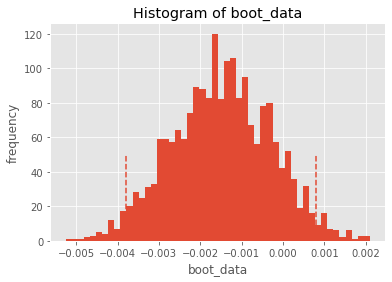

In [105]:
booted_data_2 = get_bootstrap(ab_5.x, ab_6.y, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [106]:
booted_data_1["p_value"]

0.20662172421547897

In [107]:
booted_data_2["ci"]

,0
0.0250,-0.0038
0.9750,0.0008


Результат идентичный предыдущем - разница статстически не значима, улучшения/изменения не влияют на результат конвертации пользователей